In [2]:
import os
import gc
import cv2
import torch
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
from enum import Enum
import pandas as pd
from IPython.display import display, HTML 
%matplotlib inline

In [4]:
# Loading the data, estimated labels, and corresponding ground truth
ID = 233
image = sitk.ReadImage("Data/sym_avg_mri_2023_50mu.nii.gz")

old_labels = sitk.ReadImage("Data/sym_pop_atlas_label_map_2023.nii.gz")
old_labels = (old_labels==ID) + (old_labels==10000+ID)
old_labels = sitk.Cast(old_labels,sitk.sitkUInt8)

atropos_00 = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/atropos_pw_0.0_ID_233.nii.gz",sitk.sitkUInt8)
atropos_025 = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/atropos_pw_0.25_ID_233.nii.gz",sitk.sitkUInt8)
atropos_04 = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/atropos_pw_0.4_ID_233.nii.gz",sitk.sitkUInt8)
atropos_05 = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/atropos_pw_0.5_ID_233.nii.gz",sitk.sitkUInt8)
fuzzyspatial = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/fuzzyspatial_nc_2_ID_233.nii.gz",sitk.sitkUInt8)
priorbased00 = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/priorbased_pw_0.0_ID_233.nii.gz",sitk.sitkUInt8)
priorbased025 = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/priorbased_pw_0.25_ID_233.nii.gz",sitk.sitkUInt8)
priorbased04 = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/priorbased_pw_0.4_ID_233.nii.gz",sitk.sitkUInt8)
priorbased05 = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/priorbased_pw_0.5_ID_233.nii.gz",sitk.sitkUInt8)

sam_axial = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/SAM_labels_for_id_233_axial.nii.gz",sitk.sitkUInt8)
sam_coronal = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/SAM_labels_for_id_233_coronal.nii.gz",sitk.sitkUInt8)
sam_sagittal = sitk.ReadImage("seg_results/sym_avg_mri_2023_50mu/233/SAM_labels_for_id_233_sagittal.nii.gz",sitk.sitkUInt8)

ground_truth = sitk.ReadImage("Data/symmetric_233_ground_truth.nii.gz",sitk.sitkUInt8)

labelForUndecidedPixels = 10
sam_segmentations = [sam_axial, sam_coronal, sam_sagittal]
sam_majority_vote = sitk.LabelVoting(sam_segmentations, labelForUndecidedPixels)

overal_majority_vote = sitk.LabelVoting([sam_majority_vote,atropos_05,fuzzyspatial], labelForUndecidedPixels)    

ground_truth=sitk.Cast(ground_truth, sitk.sitkUInt8)
segmentations = [sitk.Cast(atropos_00, sitk.sitkUInt8),
                 sitk.Cast(atropos_05, sitk.sitkUInt8),
                 sitk.Cast(priorbased00, sitk.sitkUInt8),
                 sitk.Cast(priorbased05, sitk.sitkUInt8),
                 sitk.Cast(fuzzyspatial, sitk.sitkUInt8),
                 sitk.Cast(sam_majority_vote, sitk.sitkUInt8),
                 sitk.Cast(overal_majority_vote, sitk.sitkUInt8),
                 sitk.Cast(old_labels, sitk.sitkUInt8)]

In [5]:
def show_segments_together (image, sam_segmentations, segmentations, ground_truth, axis_mode, slice_number, thickness):
    """
    index 0: atropos_00
    index 1: atropos_05
    index 2: priorbased00
    index 3: priorbased05
    index 4: fuzzyspatial
    index 5: sam_majority_vote
    index 6: overal_majority_vote
    index 7: old_labels
    """
    if axis_mode=="axial":
        img = image[:,:,slice_number]
        mask_sam_axial = sam_segmentations[0][:,:,slice_number]
        mask_sam_coronal = sam_segmentations[1][:,:,slice_number]
        mask_sam_sagittal = sam_segmentations[2][:,:,slice_number]
        mask_gt = ground_truth[:,:,slice_number]
        mask_sam_majority_vote = segmentations[5][:,:,slice_number]
        mask_overal_majority_vote = segmentations[6][:,:,slice_number]
        mask_old_labels = segmentations[7][:,:,slice_number]
        mask_atropos = segmentations[3][:,:,slice_number]
        mask_fuzzyspatial = segmentations[4][:,:,slice_number]
    
    elif axis_mode=="coronal":
        img = image[:,slice_number,:]
        mask_sam_axial = sam_segmentations[0][:,slice_number,:]
        mask_sam_coronal = sam_segmentations[1][:,slice_number,:]
        mask_sam_sagittal = sam_segmentations[2][:,slice_number,:]
        mask_gt = ground_truth[:,slice_number,:]
        mask_sam_majority_vote = segmentations[5][:,slice_number,:]
        mask_overal_majority_vote = segmentations[6][:,slice_number,:]
        mask_old_labels = segmentations[7][:,slice_number,:]
        mask_atropos = segmentations[3][:,slice_number,:]
        mask_fuzzyspatial = segmentations[4][:,slice_number,:]
        
    elif axis_mode=="sagittal":
        img = image[slice_number,:,:]
        mask_sam_axial = sam_segmentations[0][slice_number,:,:]
        mask_sam_coronal = sam_segmentations[1][slice_number,:,:]
        mask_sam_sagittal = sam_segmentations[2][slice_number,:,:]
        mask_gt = ground_truth[slice_number,:,:]
        mask_sam_majority_vote = segmentations[5][slice_number,:,:]
        mask_overal_majority_vote = segmentations[6][slice_number,:,:]
        mask_old_labels = segmentations[7][slice_number,:,:]
        mask_atropos = segmentations[3][slice_number,:,:]
        mask_fuzzyspatial = segmentations[4][slice_number,:,:]
    
    w,h = sitk.GetArrayViewFromImage(mask_sam_axial).shape[0], sitk.GetArrayViewFromImage(mask_sam_axial).shape[1]
    out_sam_axes = np.zeros((w,h,3)).astype(np.uint8)
    out_sam_overal = np.zeros((w,h,3)).astype(np.uint8)
    out_overal = np.zeros((w,h,3)).astype(np.uint8)
    out_old_labels = np.zeros((w,h,3)).astype(np.uint8)
    out_atropos = np.zeros((w,h,3)).astype(np.uint8)
    out_fuzzyspatial = np.zeros((w,h,3)).astype(np.uint8)
    
    contours_sam_axial, _ = cv2.findContours(sitk.GetArrayViewFromImage(mask_sam_axial).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_sam_coronal, _ = cv2.findContours(sitk.GetArrayViewFromImage(mask_sam_coronal).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_sam_sagittal, _ = cv2.findContours(sitk.GetArrayViewFromImage(mask_sam_sagittal).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_gt, _ = cv2.findContours(sitk.GetArrayViewFromImage(mask_gt).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours_sam_majority_vote, _ = cv2.findContours(sitk.GetArrayViewFromImage(mask_sam_majority_vote).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_overal_majority_vote, _ = cv2.findContours(sitk.GetArrayViewFromImage(mask_overal_majority_vote).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_atropos, _ = cv2.findContours(sitk.GetArrayViewFromImage(mask_atropos).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_old_labels, _ = cv2.findContours(sitk.GetArrayViewFromImage(mask_old_labels).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_fuzzyspatial, _ = cv2.findContours(sitk.GetArrayViewFromImage(mask_fuzzyspatial).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(out_sam_axes, contours_sam_axial, -1, (255,0,0), thickness)
    cv2.drawContours(out_sam_axes, contours_sam_coronal, -1, (0,255,0), thickness)
    cv2.drawContours(out_sam_axes, contours_sam_sagittal, -1, (0,0,255), thickness)
    cv2.drawContours(out_sam_axes, contours_gt, -1, (255,255,255), thickness)
    
    cv2.drawContours(out_sam_overal, contours_sam_majority_vote, -1, (255,0,0), thickness)
    cv2.drawContours(out_sam_overal, contours_gt, -1, (255,255,255), thickness)
    
    cv2.drawContours(out_overal, contours_overal_majority_vote, -1, (255,0,0), thickness)
    cv2.drawContours(out_overal, contours_gt, -1, (255,255,255), thickness)
    
    cv2.drawContours(out_atropos, contours_atropos, -1, (255,0,0), thickness)
    cv2.drawContours(out_atropos, contours_gt, -1, (255,255,255), thickness)
    
    cv2.drawContours(out_old_labels, contours_old_labels, -1, (255,0,0), thickness)
    cv2.drawContours(out_old_labels, contours_gt, -1, (255,255,255), thickness)
    
    cv2.drawContours(out_fuzzyspatial, contours_fuzzyspatial, -1, (255,0,0), thickness)
    cv2.drawContours(out_fuzzyspatial, contours_gt, -1, (255,255,255), thickness)
    
    fig, ax = plt.subplots(2, 3, figsize=(20, 20))
    ax[0][0].imshow(np.flipud(sitk.GetArrayViewFromImage(img)), "gray")
    ax[0][0].imshow(np.flipud(out_sam_axes),alpha=0.7)
    ax[0][0].axis('off') 
    ax[0][0].set_title("SAM segmentation results along different axes")
    
    ax[0][1].imshow(np.flipud(sitk.GetArrayViewFromImage(img)), "gray")
    ax[0][1].imshow(np.flipud(out_sam_overal),alpha=0.7)
    ax[0][1].axis('off') 
    ax[0][1].set_title("SAM majority-vote segmentation results")
    
    ax[0][2].imshow(np.flipud(sitk.GetArrayViewFromImage(img)), "gray")
    ax[0][2].imshow(np.flipud(out_atropos),alpha=0.7)
    ax[0][2].axis('off') 
    ax[0][2].set_title("Atropos results")
    
    ax[1][0].imshow(np.flipud(sitk.GetArrayViewFromImage(img)), "gray")
    ax[1][0].imshow(np.flipud(out_fuzzyspatial),alpha=0.7)
    ax[1][0].axis('off') 
    ax[1][0].set_title("Fuzzy spatial segmentation results")
    
    ax[1][1].imshow(np.flipud(sitk.GetArrayViewFromImage(img)), "gray")
    ax[1][1].imshow(np.flipud(out_overal),alpha=0.7)
    ax[1][1].axis('off') 
    ax[1][1].set_title("Majority voting for all the segmentation results")
    
    ax[1][2].imshow(np.flipud(sitk.GetArrayViewFromImage(img)), "gray")
    ax[1][2].imshow(np.flipud(out_old_labels),alpha=0.7)
    ax[1][2].axis('off') 
    ax[1][2].set_title("Old labels results")
    
    plt.savefig("out_"+axis_mode+"_"+str(slice_number)+".png")


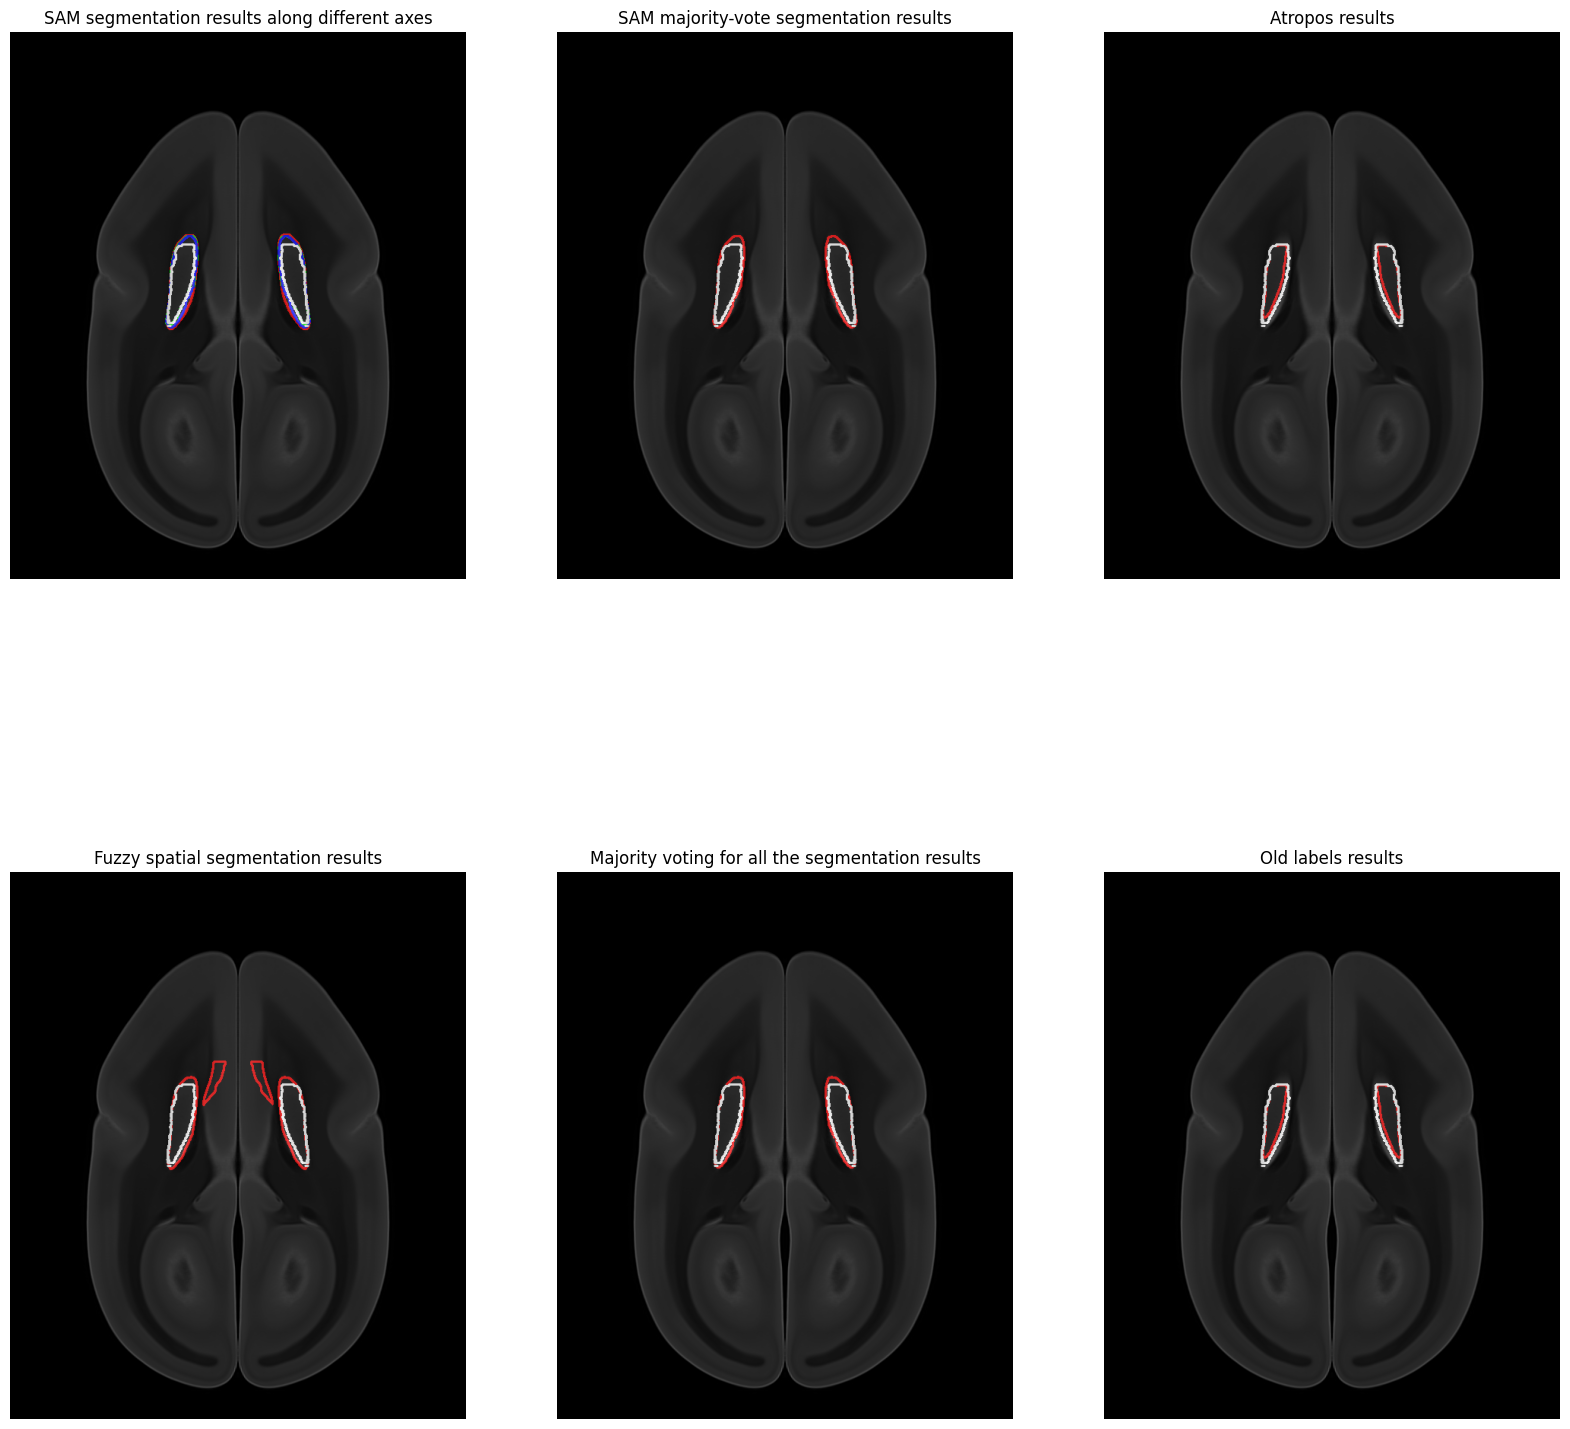

In [6]:
# white is the ground truth
show_segments_together (image, sam_segmentations, segmentations, ground_truth, axis_mode="axial", slice_number=300, thickness=2)

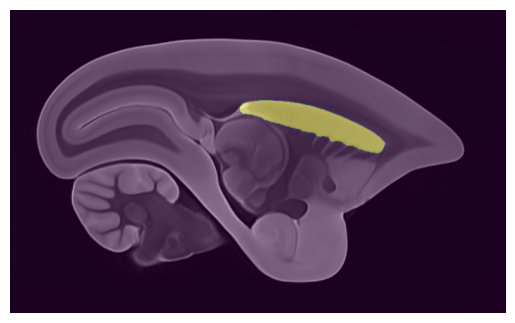

In [7]:
img = image[380,:,:]

msk = overal_majority_vote[380,:,:]
# msk = ground_truth[380,:,:]
# msk = old_labels[380,:,:]

plt.imshow(np.flipud(sitk.GetArrayViewFromImage(img)), "gray")
plt.axis('off')  
plt.imshow(np.flipud(sitk.GetArrayViewFromImage(msk)), alpha=0.4)
plt.savefig("out.png")
plt.show()


,jaccard,dice,volume_similarity,false_negative,false_positive
atropos_00,0.831,0.908,0.048,0.070,0.001
atropos_05,0.837,0.911,0.060,0.061,0.001
priorbased00,0.831,0.908,0.004,0.091,0.001
priorbased05,0.837,0.911,0.060,0.061,0.001
fuzzyspatial,0.531,0.694,0.526,0.059,0.004
sam_majority_vote,0.812,0.896,0.140,0.036,0.001
overal_majority_vote,0.818,0.900,0.142,0.031,0.001
old_labels,0.837,0.911,0.060,0.061,0.001


,hausdorff_distance,mean_surface_distance,median_surface_distance,std_surface_distance,max_surface_distance
atropos_00,0.636,0.072,0.050,0.094,0.636
atropos_05,0.642,0.071,0.000,0.099,0.642
priorbased00,0.618,0.070,0.050,0.083,0.618
priorbased05,0.642,0.071,0.000,0.099,0.642
fuzzyspatial,2.502,0.344,0.150,0.429,2.502
sam_majority_vote,0.921,0.079,0.050,0.092,0.921
overal_majority_vote,0.879,0.075,0.050,0.091,0.879
old_labels,0.642,0.071,0.000,0.099,0.642


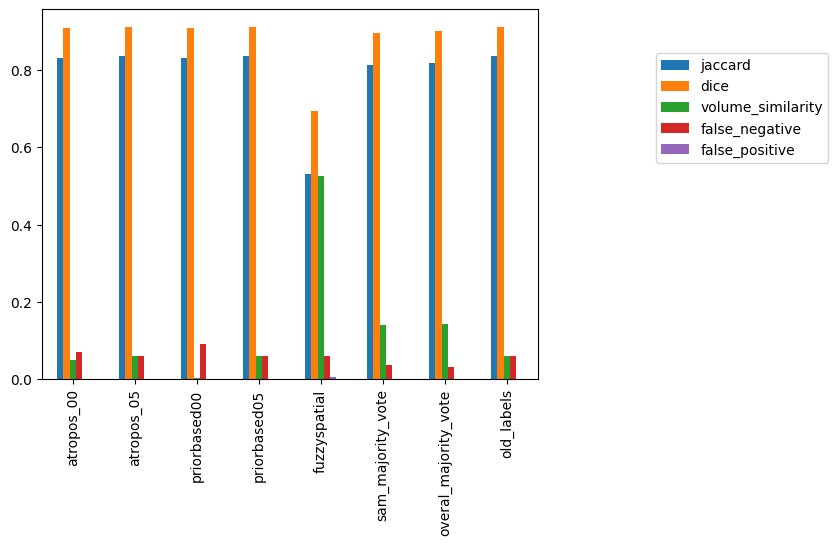

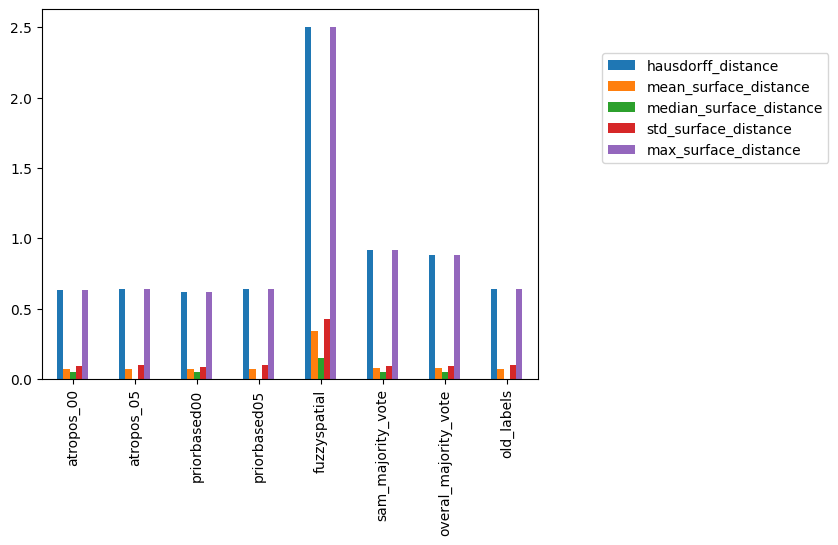

In [8]:
def evaluation (segmentations, ground_truth, methods):
    class OverlapMeasures(Enum):
        jaccard, dice, volume_similarity, false_negative, false_positive = range(5)
        
    class SurfaceDistanceMeasures(Enum):
        hausdorff_distance, mean_surface_distance, median_surface_distance, std_surface_distance, max_surface_distance = range(5)  
        
    overlap_results = np.zeros((len(segmentations),len(OverlapMeasures.__members__.items()))) 
    surface_distance_results = np.zeros((len(segmentations),len(SurfaceDistanceMeasures.__members__.items()))) 
    
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
    
    reference_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(ground_truth, squaredDistance=False, useImageSpacing=True))
    reference_surface = sitk.LabelContour(ground_truth)
    
    statistics_image_filter = sitk.StatisticsImageFilter()
    # Get the number of pixels in the reference surface by counting all pixels that are 1.
    statistics_image_filter.Execute(reference_surface)
    num_reference_surface_pixels = int(statistics_image_filter.GetSum()) 
    
    for i, seg in enumerate(segmentations):
        # Overlap measures
        overlap_measures_filter.Execute(seg, ground_truth)
        overlap_results[i,OverlapMeasures.jaccard.value] = overlap_measures_filter.GetJaccardCoefficient()
        overlap_results[i,OverlapMeasures.dice.value] = overlap_measures_filter.GetDiceCoefficient()
        overlap_results[i,OverlapMeasures.volume_similarity.value] = overlap_measures_filter.GetVolumeSimilarity()
        overlap_results[i,OverlapMeasures.false_negative.value] = overlap_measures_filter.GetFalseNegativeError()
        overlap_results[i,OverlapMeasures.false_positive.value] = overlap_measures_filter.GetFalsePositiveError()
        # Hausdorff distance
        hausdorff_distance_filter.Execute(ground_truth, seg)

        surface_distance_results[i,SurfaceDistanceMeasures.hausdorff_distance.value] = hausdorff_distance_filter.GetHausdorffDistance()
        # Symmetric surface distance measures
        segmented_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(seg, squaredDistance=False, useImageSpacing=True))
        segmented_surface = sitk.LabelContour(seg)

        # Multiply the binary surface segmentations with the distance maps. The resulting distance
        # maps contain non-zero values only on the surface (they can also contain zero on the surface)
        seg2ref_distance_map = reference_distance_map*sitk.Cast(segmented_surface, sitk.sitkFloat32)
        ref2seg_distance_map = segmented_distance_map*sitk.Cast(reference_surface, sitk.sitkFloat32)

        # Get the number of pixels in the reference surface by counting all pixels that are 1.
        statistics_image_filter.Execute(segmented_surface)
        num_segmented_surface_pixels = int(statistics_image_filter.GetSum())

        # Get all non-zero distances and then add zero distances if required.
        seg2ref_distance_map_arr = sitk.GetArrayViewFromImage(seg2ref_distance_map)
        seg2ref_distances = list(seg2ref_distance_map_arr[seg2ref_distance_map_arr!=0]) 
        seg2ref_distances = seg2ref_distances + \
                            list(np.zeros(num_segmented_surface_pixels - len(seg2ref_distances)))
        ref2seg_distance_map_arr = sitk.GetArrayViewFromImage(ref2seg_distance_map)
        ref2seg_distances = list(ref2seg_distance_map_arr[ref2seg_distance_map_arr!=0]) 
        ref2seg_distances = ref2seg_distances + \
                            list(np.zeros(num_reference_surface_pixels - len(ref2seg_distances)))

        all_surface_distances = seg2ref_distances + ref2seg_distances

        # The maximum of the symmetric surface distances is the Hausdorff distance between the surfaces. In 
        # general, it is not equal to the Hausdorff distance between all voxel/pixel points of the two 
        # segmentations, though in our case it is. More on this below.
        surface_distance_results[i,SurfaceDistanceMeasures.mean_surface_distance.value] = np.mean(all_surface_distances)
        surface_distance_results[i,SurfaceDistanceMeasures.median_surface_distance.value] = np.median(all_surface_distances)
        surface_distance_results[i,SurfaceDistanceMeasures.std_surface_distance.value] = np.std(all_surface_distances)
        surface_distance_results[i,SurfaceDistanceMeasures.max_surface_distance.value] = np.max(all_surface_distances)
        
    
    # Graft our results matrix into pandas data frames 
    overlap_results_df = pd.DataFrame(data=overlap_results, index = methods, 
                                      columns=[name for name, _ in OverlapMeasures.__members__.items()]) 
    surface_distance_results_df = pd.DataFrame(data=surface_distance_results, index = methods, 
                                      columns=[name for name, _ in SurfaceDistanceMeasures.__members__.items()]) 

    # Display the data as HTML tables and graphs
    display(HTML(overlap_results_df.to_html(float_format=lambda x: '%.3f' % x)))
    display(HTML(surface_distance_results_df.to_html(float_format=lambda x: '%.3f' % x)))
    overlap_results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))
    surface_distance_results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))
    
    
methods = ["atropos_00", "atropos_05", "priorbased00", "priorbased05","fuzzyspatial","sam_majority_vote","overal_majority_vote","old_labels"]
evaluation (segmentations, ground_truth, methods)